# Combined Algorithm Feature Ranking

For the combined algorithm feature ranking, the node features will be ranked according to results from all 4 algorithms. A node is classified as "stable" if it was classified as "stable" by 3 or 4 of the 4 algorithms, and "unstable" otherwise. The node features will be averaged across the four algorithms.

In [38]:
import os
import yaml
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

In [3]:
'''
Import all the node features
'''

lv_train_data = pd.read_csv('../LFR_Graph_Data/Louvain_Data/node_x_train.csv', index_col=0)
lv_test_data = pd.read_csv('../LFR_Graph_Data/Louvain_Data/node_x_test.csv', index_col=0)
lv_X = pd.concat([lv_train_data, lv_test_data])

im_train_data = pd.read_csv('../LFR_Graph_Data/Infomap_Data/node_x_train.csv', index_col=0)
im_test_data = pd.read_csv('../LFR_Graph_Data/Infomap_Data/node_x_test.csv', index_col=0)
im_X = pd.concat([im_train_data, im_test_data])

gn_train_data = pd.read_csv('../LFR_Graph_Data/GN_Data/node_x_train.csv', index_col=0)
gn_test_data = pd.read_csv('../LFR_Graph_Data/GN_Data/node_x_test.csv', index_col=0)
gn_X = pd.concat([gn_train_data, gn_test_data])

lpa_train_data = pd.read_csv('../LFR_Graph_Data/LPA_Data/node_x_train.csv', index_col=0)
lpa_test_data = pd.read_csv('../LFR_Graph_Data/LPA_Data/node_x_test.csv', index_col=0)
lpa_X = pd.concat([lpa_train_data, lpa_test_data])

In [4]:
'''
Import all the node labels
'''

lv_train_data = pd.read_csv('../LFR_Graph_Data/Louvain_Data/node_y_train.csv', index_col=0)
lv_test_data = pd.read_csv('../LFR_Graph_Data/Louvain_Data/node_y_test.csv', index_col=0)
lv_y = pd.concat([lv_train_data, lv_test_data])

im_train_data = pd.read_csv('../LFR_Graph_Data/Infomap_Data/node_y_train.csv', index_col=0)
im_test_data = pd.read_csv('../LFR_Graph_Data/Infomap_Data/node_y_test.csv', index_col=0)
im_y = pd.concat([im_train_data, im_test_data])

gn_train_data = pd.read_csv('../LFR_Graph_Data/GN_Data/node_y_train.csv', index_col=0)
gn_test_data = pd.read_csv('../LFR_Graph_Data/GN_Data/node_y_test.csv', index_col=0)
gn_y = pd.concat([gn_train_data, gn_test_data])

lpa_train_data = pd.read_csv('../LFR_Graph_Data/LPA_Data/node_y_train.csv', index_col=0)
lpa_test_data = pd.read_csv('../LFR_Graph_Data/LPA_Data/node_y_test.csv', index_col=0)
lpa_y = pd.concat([lpa_train_data, lpa_test_data])

### Averaging Node Features

In [14]:
node_features = ['Degree', 'Clustering Coefficient', 'Betweenness', 'Closeness', 'Shortest Path', 'Eigenvector', 
                 'E In', 'E Out', 'E In Over E Out', 'ODF', 'Expansion', 'Cut Ratio', 'Conductance', 'Normalised Cut', 
                 'Triangle Participation']

In [17]:
X = pd.DataFrame(columns=node_features)

In [32]:
feature_dfs = [lv_X, lpa_X, gn_X, im_X]

for mu in [1, 2, 3, 4]:
    for graph in [1, 2, 3, 4, 5]:
        for node in range(200):
            node_index = 'graph_{0}_{1}_node_{2}'.format(mu, graph, node)
            X_to_add = {}
            for feature in node_features:
                X_to_add[feature] = np.mean([df.loc[node_index][feature] for df in feature_dfs])
            X_to_add_df = pd.DataFrame(X_to_add, index=[node_index])
            X = pd.concat([X, X_to_add_df])

### Node Labels

In [34]:
y = pd.DataFrame(columns=['Stability'])

In [36]:
feature_dfs = [lv_y, lpa_y, gn_y, im_y]

for mu in [1, 2, 3, 4]:
    for graph in [1, 2, 3, 4, 5]:
        for node in range(200):
            node_index = 'graph_{0}_{1}_node_{2}'.format(mu, graph, node)
            stab_sum = np.sum([df.loc[node_index]['Stability'] for df in feature_dfs])
            if stab_sum >= 2:
                y_to_add = {'Stability': 1}
            elif stab_sum <= 1:
                y_to_add = {'Stability': 0}
            y_to_add_df = pd.DataFrame(y_to_add, index=[node_index])
            y = pd.concat([y, y_to_add_df])

### Train-test split

In [39]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2)

### Feature Ranking

In [40]:
runs = 100

In [57]:
feature_list = list(X_train.columns)
data = np.array(X_train)
labels = np.squeeze(np.array(y_train))
labels = labels.astype('int')

In [59]:
accuracy_scores = []
feature_importances = {}
for f in feature_list:
    feature_importances[f] = []
rows = []

skf = StratifiedKFold(n_splits=5)
rf = RandomForestClassifier()

fold_count = 0

for run in range(1, runs+1):
    
    for i in range(5):
        
        fold_count += 1
        
        folds = next(skf.split(data, labels), None)
        
        X_train_fold = data[folds[0], :]
        X_val_fold = data[folds[1], :]
        y_train_fold = labels[folds[0]]
        y_val_fold = labels[folds[1]]
        
        model = rf.fit(X_train_fold, y_train_fold)
        predictions = rf.predict(X_val_fold)
    
        accuracy_scores.append(metrics.accuracy_score(y_val_fold, predictions))

        row = { "run" : fold_count }
        for j, feature in enumerate(feature_list):
            row[feature] = rf.feature_importances_[j]
        rows.append(row)

### Accuracy Scores

In [61]:
print(accuracy_scores[:100])
print('~~~~~~~~~~~~~~~~~~~~~')
print(np.mean(accuracy_scores))

[0.9328125, 0.93125, 0.9359375, 0.934375, 0.9328125, 0.9328125, 0.93125, 0.93125, 0.93125, 0.93125, 0.9359375, 0.93125, 0.9359375, 0.93125, 0.93125, 0.9328125, 0.93125, 0.934375, 0.934375, 0.9328125, 0.925, 0.9328125, 0.9296875, 0.93125, 0.9296875, 0.9328125, 0.9328125, 0.934375, 0.9375, 0.9328125, 0.93125, 0.934375, 0.93125, 0.9296875, 0.934375, 0.934375, 0.9328125, 0.9359375, 0.9328125, 0.928125, 0.928125, 0.9296875, 0.9328125, 0.93125, 0.934375, 0.934375, 0.9359375, 0.9296875, 0.93125, 0.93125, 0.9328125, 0.9328125, 0.93125, 0.934375, 0.93125, 0.9328125, 0.9296875, 0.934375, 0.934375, 0.93125, 0.9359375, 0.9375, 0.9328125, 0.9328125, 0.93125, 0.928125, 0.93125, 0.9359375, 0.928125, 0.9359375, 0.934375, 0.9328125, 0.9328125, 0.934375, 0.9296875, 0.925, 0.9296875, 0.9359375, 0.9296875, 0.93125, 0.93125, 0.9328125, 0.93125, 0.928125, 0.9359375, 0.934375, 0.934375, 0.9328125, 0.9328125, 0.9328125, 0.934375, 0.93125, 0.93125, 0.928125, 0.9328125, 0.9234375, 0.93125, 0.9359375, 0.934375, 

### Ranking Plot

In [62]:
df_importances = pd.DataFrame(rows).set_index("run")

In [63]:
feature_ranking = df_importances.mean().sort_values(ascending=False)

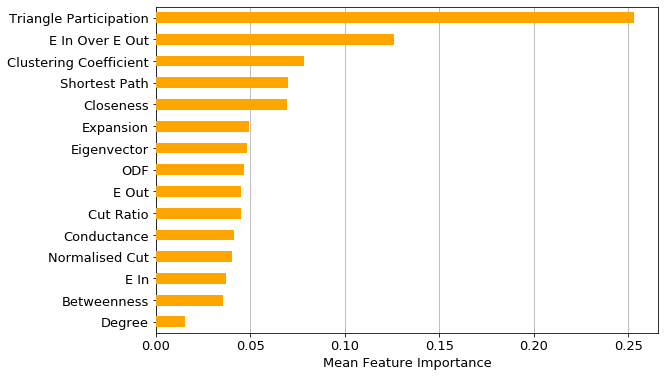

In [64]:
ax = feature_ranking[::-1].plot.barh(fontsize=13, figsize=(9,6), color="orange", zorder=3)
ax.set_xlabel("Mean Feature Importance", fontsize=13)
ax.xaxis.grid()